#### This notebook finds the average globally-averaged (zonal and meridional) temperature profile in the control simulation.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:42111 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,169527
1,1deg_jra55_ryf_rcp45cool_spinup500,42426
2,1deg_jra55_ryf_rcp45warm_spinup500,47726
3,1deg_jra55_ryf_rcp45cool_spinup400,21206
4,1deg_jra55_ryf_rcp45warm_spinup400,21206
5,1deg_jra55_ryf_rcp45cool_x2_spinup500,42426
6,1deg_jra55_ryf_rcp45warm_x2_spinup500,42426
7,1deg_jra55_ryf_rcp45warm_x1_spinup500,42426
8,1deg_jra55_ryf_rcp45cool_x1_spinup500,42426
9,1deg_jra55_ryf_warm_0sat_8dwlw_spinup500,21206


In [10]:
yr_beg = '2400-01-16'

expt = '1deg_jra55_ryf_cont'
var = 'temp'
frequency = '1 monthly'
temp_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto').load()

  warnings.warn(



In [17]:
variable_to_average = temp_cont
coord = 'geolat_t'
variable_as_coord = cc.querying.getvar(expt, coord, session, n=1).load()
yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1).load()
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 
dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg).groupby('time.year').mean(dim='time') #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t).load() #Volume of cells

histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol, dim = ['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins = [bins], weights = dVol * variable_to_average, dim = ['yt_ocean', 'xt_ocean'])
temp_cont_zonal_ave = (histTVolCoordDepth / histVolCoordDepth)

  warnings.warn(



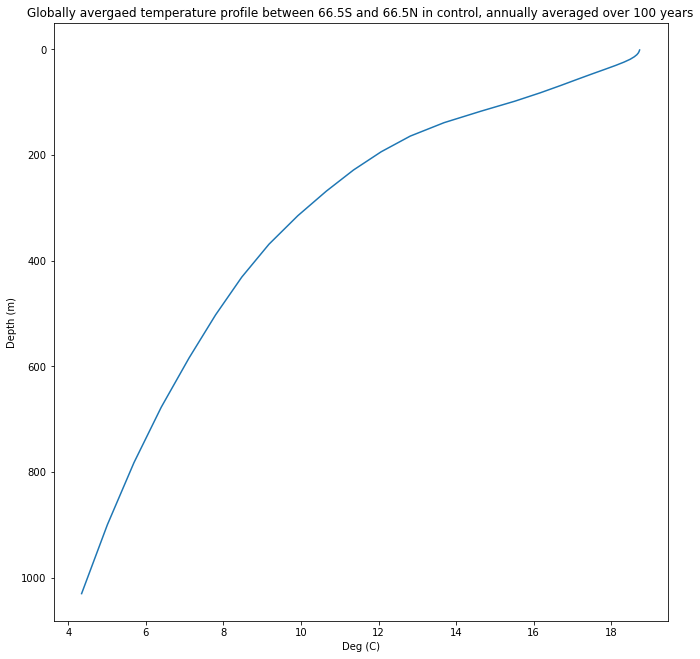

In [84]:
plt.figure(figsize=(11,11))
lat_lim = 66.5
plt.plot((temp_cont_zonal_ave.sel(st_ocean = slice(0, 1050)).sel(geolat_t_bin = slice(-lat_lim, lat_lim)).mean(dim = 'geolat_t_bin').mean(dim = 'year') - 273.15).values, \
         (temp_cont_zonal_ave.sel(st_ocean = slice(0, 1050)).sel(geolat_t_bin = slice(-lat_lim, lat_lim)).mean(dim = 'geolat_t_bin').mean(dim = 'year')['st_ocean']))
plt.title('Globally avergaed temperature profile between {}S and {}N in control, annually averaged over 100 years'.format(lat_lim, lat_lim))
plt.xlabel('Deg (C)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()

In [80]:
T_for_one_dim_model = temp_cont_zonal_ave.sel(st_ocean = slice(0, 1050)).sel(geolat_t_bin = slice(-lat_lim, lat_lim)).mean(dim = 'geolat_t_bin').mean(dim = 'year') - 273.15
T_t = T_for_one_dim_model.values
z_t = T_for_one_dim_model['st_ocean'].values

In [81]:
T_t, z_t

(array([27.14607106, 27.13324037, 27.11532038, 27.09157359, 27.05303047,
        26.99940227, 26.90575061, 26.7421736 , 26.47303201, 26.07777922,
        25.55533381, 24.8782619 , 23.96874268, 22.71262596, 21.01500463,
        19.13799197, 17.45100166, 16.03286975, 14.75540181, 13.53766921,
        12.29218774, 11.08185742,  9.98923226,  8.97820451,  8.04806038,
         7.17267913,  6.32982906,  5.52776851,  4.7684474 ]),
 array([   1.15174985,    3.64867401,    6.56491852,    9.97086906,
          13.94870853,   18.59437943,   24.01987267,   30.35588455,
          37.75489044,   46.39470291,   56.48257065,   68.25986481,
          82.00740814,   98.0514679 ,  116.7703476 ,  138.60160828,
         164.04943848,  193.69206238,  228.18814087,  268.28121948,
         314.8001709 ,  368.65353394,  430.81393433,  502.28930664,
         584.0770874 ,  677.10028076,  782.12670898,  899.6817627 ,
        1029.96813965]))